In [1]:
import torch
import torchvision
import detectron2
import numpy as np

import os, json, random
from pathlib import Path
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt

from skimage.io import imread, imsave

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
import pandas as pd

import utils

## Setting up training, validation and test groups
Should use all MoNuSeg data, not only the test data

In [2]:
monuseg_patinfo = pd.read_csv(Path(os.getcwd()).parent / 'data/monuseg/patient_information.csv')

monuseg_train_ids = monuseg_patinfo[monuseg_patinfo['training'] == 'yes']['patient_id']
monuseg_test_ids = monuseg_patinfo[monuseg_patinfo['training'] == 'no']['patient_id']
monuseg_train_ids, monuseg_val_ids = utils.val_split(monuseg_train_ids)

In [28]:
from detectron2.structures import BoxMode
from typing import List, Dict
from joblib import Memory
memory = Memory("./cache", verbose=0)

def crop_image(file_name : str, factor : int):
    path = Path(file_name)
    im = imread(file_name)
    file_names = []
    for idx, i in enumerate(np.split(im, factor, axis=0)):
        for idy, j in enumerate(np.split(i, factor, axis=1)):
            cropped_file_name = f"{path.parent}/cropped_{idx}{idy}{path.name}"
            file_names.append(cropped_file_name)
            imsave(cropped_file_name, j)
            
    return file_names

from scipy.spatial import distance
def _fix_coords(coords):
    fixed = [coords.pop()]
    for i in range(len(coords)):
        latest =fixed[-1]
        try:
            nearest = min(coords, key=lambda c: distance.euclidean(fixed[-1], c))
        except:
            print(coords, fixed[-1])
        coords.remove(nearest)
        fixed.append(nearest)
    return fixed


In [25]:
 
            
def crop_annotation(anno: List[List[tuple]], factor : int, shape=(1000, 1000)):
    array = np.zeros(shape=(shape + (len(anno),)))
    for z, obj in enumerate(anno):
        for x, y in obj:
            array[x-2, y-2, z] = 1
            
    anno_list = []
    for idx, i in enumerate(np.split(array, factor, axis=0)):
        for idy, j in enumerate(np.split(i, factor, axis=1)):
            anno_cropped = [np.transpose(np.where(j[...,n]==1)) for n in range(j.shape[-1]) if np.any(j[...,n])]
            anno_list.append(anno_cropped)
            
    return anno_list
            

In [66]:
def get_nuclei_dicts(patient_ids : List[str]) -> List[Dict]:
    im_dir = '../data/monuseg/images'
    width, height = (1000, 1000)
    crop_factor = 10
    
    dataset_dicts = []
    for pid in patient_ids:
        file_names = str(im_dir + f"/{pid}.png")
        
        cropped_anno = crop_annotation(utils.get_annotation(pid), crop_factor)
        cropped_img = crop_image(file_names, crop_factor)
        
        for anno, file_name in zip(cropped_anno, cropped_img):
            record = {}
            record["file_name"] = file_name
            record["image_id"] = Path(file_name).name
            record["height"] = height / crop_factor
            record["width"] = width / crop_factor

            objs = []
            for a in anno:
                if len(a) < 6:
                    break
                px, py = zip(*_fix_coords([tuple(xy) for xy in a]))
                poly = [(x + 2.5, y + 2.5) for x, y in zip(px, py)]
                poly = [p for x in poly for p in x]

                obj = {
                    "xy" : list(zip(px, py)),
                    "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": [poly],
                    "category_id": 0,
                }
                objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
    return dataset_dicts
            

In [6]:
DatasetCatalog.register("nuclei_train", lambda :get_nuclei_dicts(monuseg_train_ids))
MetadataCatalog.get("nuclei_train").set(thing_classes=["nuclei"])

DatasetCatalog.register("nuclei_val", lambda : get_nuclei_dicts(monuseg_val_ids))
MetadataCatalog.get("nuclei_val").set(thing_classes=["nuclei"])

nuclei_metadata = MetadataCatalog.get("nuclei_train")

In [67]:
dataset_dicts = get_nuclei_dicts(monuseg_train_ids[0:1])

(46, 45, 45, 44, 44, 43, 43, 42, 42, 41, 41, 41, 40, 40, 39, 39, 38, 37, 36, 36, 35, 34, 33, 33, 32, 31, 31, 30, 30, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 31, 31, 32, 32, 33, 33, 34, 34, 35, 36, 36, 37, 38, 39, 40, 41, 42, 43, 43, 44, 44, 45, 45, 46, 46, 46)
(66, 65, 65, 64, 63, 62, 61, 61, 60, 59, 59, 58, 58, 57, 57, 56, 56, 55, 54, 53, 53, 52, 51, 50, 49, 48, 48, 48, 47, 47, 47, 47, 47, 47, 48, 48, 49, 49, 49, 50, 50, 51, 51, 52, 52, 53, 54, 54, 55, 55, 56, 56, 57, 58, 59, 60, 61, 62, 62, 63, 64, 65, 65, 66, 66, 66, 66)
(61, 61, 61, 60, 60, 60, 60, 59, 59, 58, 57, 57, 56, 55, 54, 53, 52, 51, 50, 49, 49, 48, 48, 47, 46, 46, 45, 45, 45, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 46, 46, 47, 47, 47, 48, 49, 50, 51, 51, 52, 53, 54, 54, 55, 56, 56, 57, 57, 58, 58, 59, 59, 60, 60, 60)
(32, 31, 31, 30, 30, 29, 28, 28, 27, 26, 26, 25, 24, 24, 23, 22, 21, 20, 20, 19, 19, 18, 18, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 20, 29, 30, 31, 31, 32, 32, 32, 32, 32, 32, 32)


ValueError: not enough values to unpack (expected 2, got 0)

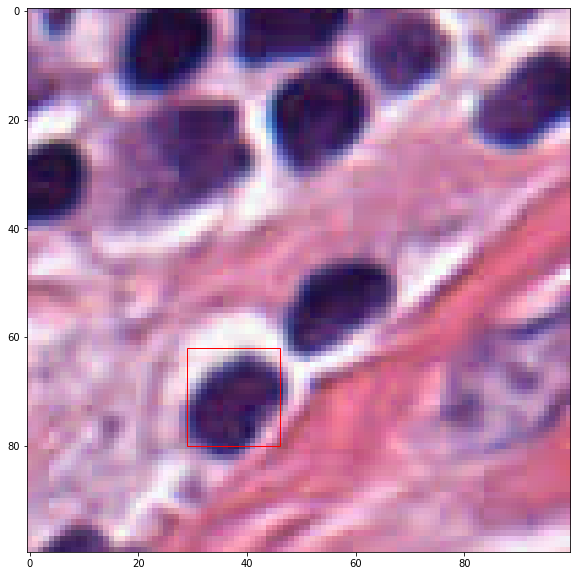

In [64]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from cycler import cycler

def draw_coco(coco_dict):
    fig,ax = plt.subplots(1, figsize=(10,10))
    im = imread(coco_dict["file_name"])
        
    ax.imshow(im)
    for obj in coco_dict["annotations"]:
        # Bounding box
        xmin, ymin, xmax, ymax = obj["bbox"]
        bbox = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(bbox)
        
        # Mask
        mask = patches.Polygon(obj["xy"], alpha = 0.5)
        ax.add_patch(mask)
    plt.show()


draw_coco(dataset_dicts[0])

In [ ]:
from detectron2.engine import DefaultTrainer
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
import wandb
wandb.init(sync_tensorboard=True)


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("nuclei_train",)
cfg.DATASETS.TEST = ("nuclei_val",)
cfg.DATALOADER.NUM_WORKERS = 0
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 800    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)
cfg.MODEL.FPN.RPN_ANCHOR_START_SIZE = 8
cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 200
cfg.MODEL.POST_NMS_TOPK_TRAIN = 200

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
import logging
logger = logging.getLogger("d2")
logger.setLevel(logging.ERROR)
trainer.train()

In [ ]:
# cfg already contains everything we've set previously. Now we changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
predictor = DefaultPredictor(cfg)

In [ ]:
def draw_coco(coco_dict : Dict):
    fig,ax = plt.subplots(1, figsize=(10,10))
    im = imread(coco_dict["file_name"])
        
    ax.imshow(im)
    for obj in coco_dict["annotations"]:
        # Bounding box
        xmin, ymin, xmax, ymax = obj["bbox"]
        bbox = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(bbox)
        
        # Mask
        mask = patches.Polygon(obj["xy"], alpha = 0.3)
        ax.add_patch(mask)
    return ax

def draw_prediction(prediction, ax):
    boxes = prediction["instances"].pred_boxes
    print(len(boxes))
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        bbox = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(bbox)
    
    
for d in random.sample(dataset_dicts, 1):    
    im = imread(d["file_name"])
    ax = draw_coco(d)
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    draw_prediction(outputs, ax)
    plt.show()